In [1]:
from rnn import MyGRU, MyLSTM, VanillaRNN, RNN
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
%load_ext autoreload
%autoreload 2

In [2]:
# Download the downsampled data frame from csv-file.
raw_data_1 = pd.read_csv(r'data\3452_building_data.csv')
raw_data = pd.read_csv(r'data\s_building_data.csv')

In [3]:
raw_data

,Time,Floor_network_2_temperature,Radiator_network_1_temperature,Ventilation_network_1_temperature,Outside_temperature_average,District_heat_temperature,Domestic_water_network_1_primary_valve,Domestic_water_network_1_temperature,Inside_temperature,CO2_concentration,Energy_consumption,Outside_humidity,Solar_irradiance
0,2021-11-29 09:00:00+00:00,31.4,50.2,46.2,-7.30,91.0,27.3,58.0,21.829167,490.666667,102.0,88,11.2
1,2021-11-29 10:00:00+00:00,30.4,50.8,45.5,-6.70,90.1,28.3,57.9,21.829167,492.291667,104.0,88,7.3
2,2021-11-29 10:00:00+00:00,30.4,50.8,45.5,-6.70,90.1,28.3,57.9,21.829167,492.291667,112.0,88,7.3
3,2021-11-29 11:00:00+00:00,31.0,50.7,46.7,-7.00,90.4,28.1,58.0,21.891667,514.583333,102.0,89,164.4
4,2021-11-29 11:00:00+00:00,31.0,50.7,46.7,-7.00,90.4,28.1,58.0,21.891667,514.583333,101.0,89,164.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2744,2022-02-14 00:00:00+00:00,27.9,37.0,37.3,1.84,79.5,27.4,58.0,21.262500,442.250000,61.0,94,1.3
2745,2022-02-14 01:00:00+00:00,27.5,37.5,37.4,1.96,79.6,28.2,58.0,21.279167,447.083333,57.0,95,1.3
2746,2022-02-14 02:00:00+00:00,28.0,36.4,37.2,2.14,79.4,29.6,58.0,21.262500,441.416667,61.0,96,0.9
2747,2022-02-14 03:00:00+00:00,27.5,36.7,37.5,2.09,79.1,29.9,58.0,21.254167,440.075000,59.0,96,1.3


In [4]:
raw_data_1

,timestamp,District_heat_temperature,Domestic_water_network_1_temperature,Radiator_network_1_temperature,Radiator_network_1_primary_valve,Ventilation_network_1_temperature,Ventilation_network_1_primary_valve,Ventilation_network_1_secondary_valve,control_on,control_off,Energy_consumption,Inside_temperature,CO2_concentration,avg_pressure_difference,Outside_temperature_average,Outside_humidity,Solar_irradiance,Radiator_network_1_temperature_setpoint
0,2021-08-30 10:00:00+00:00,65.947962,57.910778,22.673476,2.1,24.327392,1.700000,0,0.000000,20.487658,8,NaN,NaN,NaN,18.5,60.0,192.0,20.487658
1,2021-08-30 11:00:00+00:00,65.725002,57.615866,22.440869,2.1,24.593261,1.700000,0,0.000000,20.503261,13,NaN,NaN,NaN,19.6,50.0,165.4,20.503261
2,2021-08-30 12:00:00+00:00,64.992034,57.945147,22.333406,2.1,24.818260,1.700000,0,0.000000,20.283479,11,NaN,NaN,NaN,19.9,50.0,613.1,20.283479
3,2021-08-30 13:00:00+00:00,64.152763,57.883110,22.190872,2.1,25.018258,1.700000,0,0.000000,20.020074,4,NaN,NaN,NaN,19.6,48.0,516.6,20.020074
4,2021-08-30 14:00:00+00:00,63.293637,57.980074,22.109129,2.1,25.216591,1.700000,0,0.000000,20.048258,12,NaN,NaN,NaN,19.4,52.0,413.5,20.048258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5991,2022-05-16 10:00:00+00:00,67.885780,57.907325,30.137788,2.1,25.095299,2.414291,0,26.350716,33.660982,13,22.221818,532.543333,-1.618571,11.4,47.0,242.1,26.350716
5992,2022-05-16 11:00:00+00:00,67.928442,58.414225,29.577089,2.1,25.035445,2.389110,0,26.171778,33.169998,20,22.110909,527.103333,-1.370000,11.8,44.0,241.8,26.171778
5993,2022-05-16 12:00:00+00:00,68.402453,58.024998,28.887748,2.1,24.632535,2.612560,0,25.890734,31.661183,18,21.949091,455.390000,-2.457143,12.0,45.0,318.8,25.890734
5994,2022-05-16 13:00:00+00:00,67.654087,57.984150,28.007198,2.1,24.168461,1.332696,0,26.173688,30.518626,11,21.928182,449.430000,-4.917143,12.4,44.0,353.2,26.173688


In [5]:
# RUN IF COMPARING S-BUILDING AND TAMPERE

# Apply extra preprocessing to the Tampere building(s)
raw_data_1.rename(columns={'timestamp': 'Time',
                        }, inplace=True)
raw_data_1["Energy_consumption"] = raw_data_1["Energy_consumption"] * 1000
raw_data_1 = raw_data_1.drop("CO2_concentration", axis = 1)
raw_data_1 = raw_data_1.iloc[:-2]
# Drop NAs from the certain columns
todrop = raw_data_1[raw_data_1['Outside_humidity'].isna()].index.values
raw_data_1 = raw_data_1.drop(todrop, axis = 0)
todrop = raw_data_1[raw_data_1['Solar_irradiance'].isna()].index.values
raw_data_1 = raw_data_1.drop(todrop, axis = 0)

# Select the latest part of the data to speed up the training and roughly match the training periods. 
#NB! Worth changing it for inference in summer time.

#raw_data_1 = raw_data_1.iloc[7595:]

# Trim both datasets to the highest possible amount of common features
# raw_data.columns.values # To view the columns in a dataset

raw_data_1 = raw_data_1[["Time", "District_heat_temperature", "Domestic_water_network_1_temperature", "Energy_consumption", 
                         "Radiator_network_1_temperature", "Ventilation_network_1_temperature",
                         "Outside_temperature_average", "Outside_humidity", "Solar_irradiance"]]
raw_data = raw_data[["Time", "District_heat_temperature", "Domestic_water_network_1_temperature", "Energy_consumption", 
                         "Radiator_network_1_temperature", "Ventilation_network_1_temperature",
                         "Outside_temperature_average", "Outside_humidity", "Solar_irradiance"]]

hvac_model_1 = MyGRU(quant=['Energy_consumption'], seq=12, fut=0, parameters=['District_heat_temperature',
       'Domestic_water_network_1_temperature', 
#         'Energy_consumption',
       'Radiator_network_1_temperature',
       'Ventilation_network_1_temperature', 'Outside_temperature_average',
       'Outside_humidity', 'Solar_irradiance'])

x_train_1, y_train_1, x_test_1, y_test_1 = hvac_model_1.preprocess(raw_data_1, 0.2)

Shape of training data: (4777, 12, 7)
Shape of testing data: (1186, 12, 7)


In [6]:
# Initialize the model with the required parameters. Change the parameters if applying another dataset.
hvac_model = MyGRU(quant=['Energy_consumption'], seq=12, fut=0, parameters=['District_heat_temperature',
       'Domestic_water_network_1_temperature', 
#         'Energy_consumption',
       'Radiator_network_1_temperature',
       'Ventilation_network_1_temperature', 'Outside_temperature_average',
       'Outside_humidity', 'Solar_irradiance'])
              
# Scale, split, and sequence the downsampled data frame.
# x_train, y_train, x_test, y_test = hvac_model.preprocess(raw_data, 0.1)
x_train, y_train, x_test, y_test,df_train,df_val= hvac_model.preprocess_output_date(raw_data, 0.2)

D:\anaconda\envs\smtct\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
F:\hamk\smart_city\talotohtori\HAMK_Smart_City\rnn.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['weekday'] = [t.timetuple().tm_wday for t in datetimes]
F:\hamk\smart_city\talotohtori\HAMK_Smart_City\rnn.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

Shape of training data: (2187, 12, 7)
Shape of testing data: (538, 12, 7)


In [7]:
# # Train the model using custom fit method. 
# # Does hyperparameter optimization automatically in pre-defined search space. Comment row below, if you have already trained the model.
# hvac_model.fit(X=x_train, y=y_train, epochs=1000, max_trials=15)
# hvac_model.save()

In [8]:
# Uncomment below to load the existing model, scaler and other variables, if you have the model trained already.

hvac_model.load(r'model\GRU_Energy_consumption_s')

Model loaded.
Scaler loaded.
Other variables loaded.


In [9]:
# # Calculating prediction intervals using bootstrap
# rounds = 12     # Number of data instances to calculate prediction intervals to.

# for i in range(rounds):
    
#     # Calculating prediction percentiles and saving them to a csv file.
#     hvac_model.prediction_interval(x_train, y_train, x_test[i])     # NB! The process is computationally intensive.

In [10]:
# # Load the existing intervals if they have been predicted
# low, up = hvac_model.load_intervals(r'F:\hamk\smart_city\roman\HAMK_Smart_City\GRU_Energy_consumption_2022-08-18/pred_ints.csv')

In [11]:
# Use the existing confidence interval multipliers (assuming Gaussian distribution) for the prediction of the intervals
probability_multipliers = {"50": 0.67, "55": 0.76, "60": 0.84, "65": 0.93, "70": 1.04, "75": 1.15, "80": 1.28,
                           "85": 1.44, "90": 1.64, "95": 1.96, "96": 2.05, "97": 2.17, "98": 2.33, "99": 2.58}

def predict_intervals(probability, measurements, predictions):
    '''
    Function for prediction of the confidence intervals using the residual standard deviation method.
    Inputs: desired confidence interval value as string, array of the predictions, array of the measurements
    Outputs: array of lower-bound confidence, array of upper-bound confidence
    '''
    assert probability in probability_multipliers, "Please select the probability from the dictionary"
    low = []
    up = []
    sq_residuals = []
    for  measurement,prediction in zip(measurements, predictions):
        sq_residuals.append(((measurement - prediction)**2)[0])
    sq_residuals = np.array(sq_residuals)
    res_stdev = np.sqrt(np.sum(sq_residuals) / (len(sq_residuals)-1))
    multiplier = probability_multipliers[probability]
    for measurement in measurements:
        low.append((measurement - multiplier * res_stdev)[0])
        up.append((measurement + multiplier * res_stdev)[0])
    low = np.array(low)
    up = np.array(up)
    low = low.flatten()
    up = up.flatten()
    return low, up

In [12]:
# Making test predictions with the RNN model.
# Predictions for the original data
train_preds = hvac_model.model.predict(x_train)
test_preds = hvac_model.model.predict(x_test)

# Predictions for the data without the offsets
train_preds_1 = hvac_model.model.predict(x_train_1)
test_preds_1 = hvac_model.model.predict(x_test_1)

# Loading prediction intervals from disk.
#low, up = hvac_model.load_intervals(r'C:\Users\romat\Documents\GitHub\HAMK_Smart_City\GRU_Inside_temperature_2022-01-10\pred_ints.csv')

# Invert target variables both for measured values and computed predictions.
inv_preds_train, inv_y_train = hvac_model.inv_target(x_train, train_preds, y_train)
inv_preds_test, inv_y_test = hvac_model.inv_target(x_test, test_preds, y_test)

# Same for the data from the other dataset 
inv_preds_train_1, inv_y_train_1 = hvac_model.inv_target(x_train_1, train_preds, y_train_1)

In [13]:
print("Train MSE: " + "{:.3f}".format(mean_squared_error(inv_preds_train, inv_y_train)))
print("Train RMSE: " + "{:.3f}".format(np.sqrt(mean_squared_error(inv_preds_train, inv_y_train))))
print("Train MAE: " + "{:.3f}".format(mean_absolute_error(inv_preds_train, inv_y_train)))
print("Train MAPE: " + "{:.3f}%".format(100*mean_absolute_percentage_error(inv_preds_train, inv_y_train)))
print("Test MSE: " + "{:.3f}".format(mean_squared_error(inv_preds_test, inv_y_test)))
print("Test RMSE: " + "{:.3f}".format(np.sqrt(mean_squared_error(inv_preds_test, inv_y_test))))
print("Test MAE: " + "{:.3f}".format(mean_absolute_error(inv_preds_test, inv_y_test)))
print("Test MAPE: " + "{:.3f}%".format(100*mean_absolute_percentage_error(inv_preds_test, inv_y_test)))

Train MSE: 21.936
Train RMSE: 4.684
Train MAE: 3.572
Train MAPE: 3.693%
Test MSE: 15.468
Test RMSE: 3.933
Test MAE: 2.743
Test MAPE: 3.673%


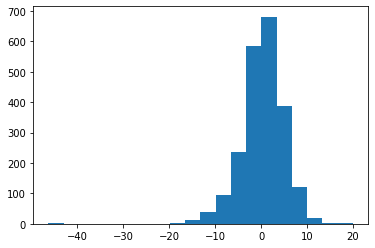

In [14]:
# Assess the distribution of the residuals
plt.hist(inv_preds_train - inv_y_train, bins = 20)
plt.show()

# Predict the intervals
#low, up = hvac_model.inv_target(x_test, low, up)
low, up = predict_intervals("85", inv_y_train_1, inv_preds_train_1)

In [15]:
# # Plot model prediction alongside measured values.
# hvac_model.plot_preds(inv_preds_train_1[1000:1500], inv_y_train_1[1000:1500], low[1000:1500], up[1000:1500])

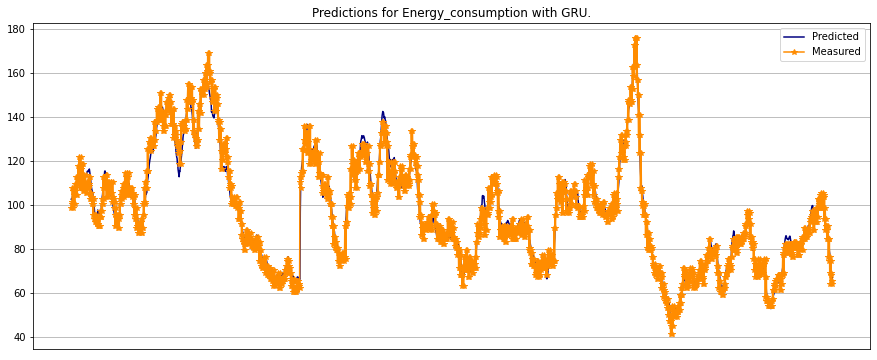

In [16]:
hvac_model.plot_preds(inv_preds_train, inv_y_train)

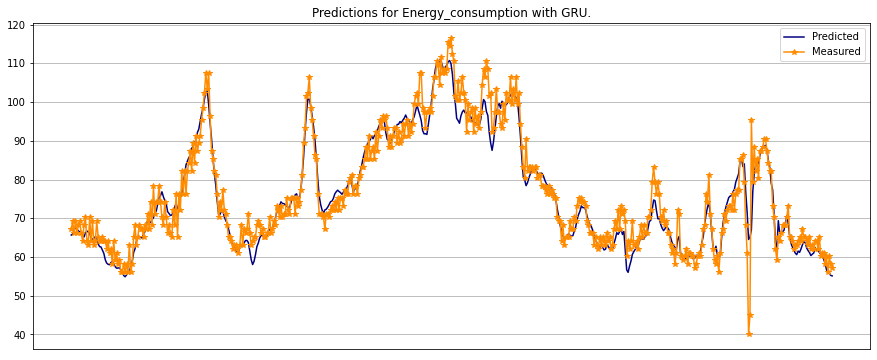

In [17]:
hvac_model.plot_preds(inv_preds_test, inv_y_test)

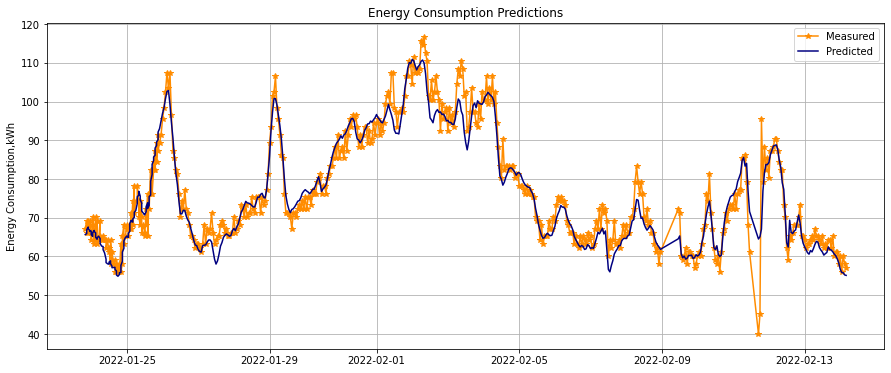

In [18]:
    plt.figure(figsize=(15, 6)) 
    plt.plot(np.array(df_val[12:]),inv_y_test[:].reshape(-1),color='darkorange',marker = '*', label='Measured') 
    plt.plot(np.array(df_val[12:]),inv_preds_test[:].reshape(-1),color='navy', label='Predicted')
    plt.ylabel("Energy Consumption,kWh")
    plt.title(f'Energy Consumption Predictions')
    plt.legend()
    plt.grid(axis = "both")
#     plt.savefig('./output/sbuilding/article/energy.png')


    plt.show()
   

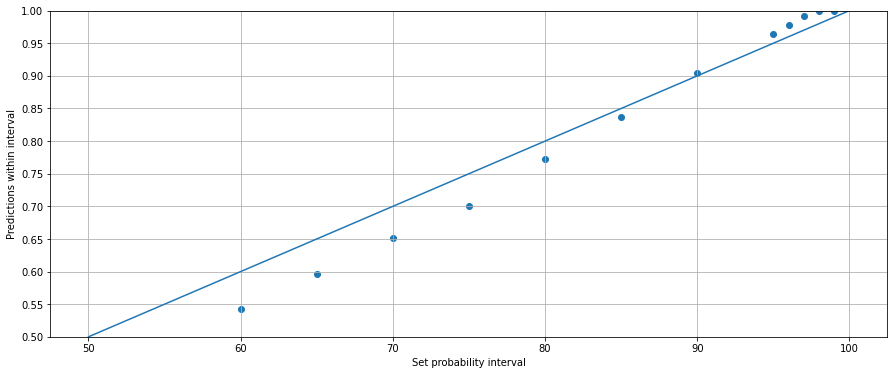

In [19]:
# Calculate percentages falling in the prediction interval to retroactively assess the residual standard deviation method
percentages = []
for probability in probability_multipliers:
    lows, ups = predict_intervals(probability, inv_y_train_1, inv_preds_train_1)
    num = 0
    denum = len(lows)
    for i, j, k in zip(lows, inv_preds_train, ups):
        if i < j < k:
            num += 1
    percentages.append(num / denum)
plt.figure(figsize = (15, 6))
plt.scatter([50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 96, 97, 98, 99], percentages)
plt.plot([50, 100], [0.5, 1])
plt.yticks(np.arange(0.0, 1.1, 0.05))
plt.ylim(bottom = 0.5, top = 1)
plt.grid(axis = "both")
plt.xlabel("Set probability interval")
plt.ylabel("Predictions within interval")
plt.show()